# Opt4ML project

In [1]:
# General libraries
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Pad
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os import listdir
from os.path import join, isfile
from collections import Counter
import random
# Custom libraries
from plot_helpers import *
from image_processing_helpers import *
from k_means import *
import custom_optimizers as opt
# Allow autoreload
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = "cpu"
#print(device)

## Import Data

In [3]:
class Fashion_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None, target_transform=None):
        data = pd.read_csv(data_path)
        self.labels_df = data["label"]
        self.img_labels = data["label"].to_list()
        self.images = [(row.to_numpy(dtype=np.float32)/255).reshape((28,28))  
                for idx,row in data[data.columns[1:]].iterrows()]
        self.label_mapping = {0:"T-shirt/top", 1:"Trouser",
                 2:"Pullover", 3:"Dress", 4:"Coat",
                 5:"Sandal", 6:"Shirt", 7:"Sneaker",
                 8:"Bag", 9:"Ankle boot"}
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        image = Pad(2)(image)
        return image, label

In [4]:
train_dataset = Fashion_Dataset("data/fashion_mnist/fashion-mnist_train.csv",transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test_dataset = Fashion_Dataset("data/fashion_mnist/fashion-mnist_test.csv",transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

In [5]:
train_dataloader = DataLoader(train_dataset,batch_size=4096,shuffle=True)
test_dataloader = DataLoader(train_dataset,batch_size=4096,shuffle=True)

## EDA

#### Data example

Feature batch shape: torch.Size([4096, 1, 32, 32])
Labels batch shape: torch.Size([4096, 10])
Labels: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


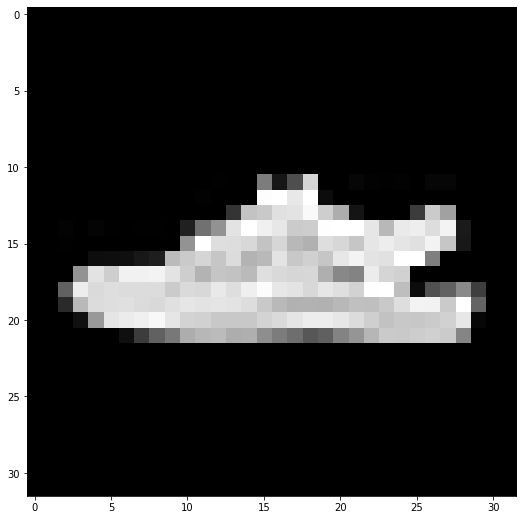

In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:,:]
label = train_labels[0]
show_images([img])
print(f"Labels: {label}")

#### Labels Distribution

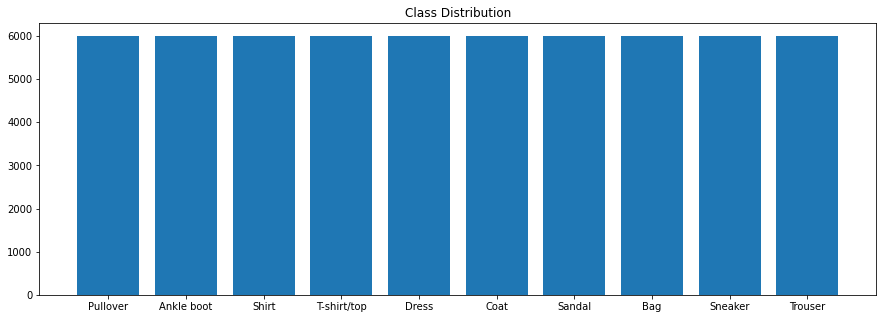

In [7]:
labels_hist = train_dataset.labels_df.value_counts().to_dict()
fig,ax = plt.subplots(figsize=(15,5))
labels_names = [train_dataset.label_mapping[i] for i in labels_hist.keys()]
ax.bar(labels_names,labels_hist.values())
ax.set_title("Class Distribution");

## Model Creation

#### Model Architecture

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*16*32, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

#### Criterium and loss

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = opt.SGDOptimizer(model.parameters(),lr=1e-3)

## Training

In [12]:
max_epoch = 10
for epoch in range(max_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2 == 1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
            running_loss = 0.0

print('Finished Training')

C:\Users\jerem\AppData\Local\Temp\ipykernel_8620\4106858249.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


[1,     2] loss: 2.298
[1,     4] loss: 2.270
[1,     6] loss: 2.228
[1,     8] loss: 2.181
[1,    10] loss: 2.139
[1,    12] loss: 2.106
[1,    14] loss: 2.072
[2,     2] loss: 2.038


KeyboardInterrupt: 

## Testing

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        _, truth_label = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted == truth_label).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

---

## Import Data

In [ ]:
def load_data(folder_path):
    files = [cv2.imread(join(folder_path,f)) for f in listdir(folder_path) 
             if os.path.isfile(join(folder_path,f))]
    return files

In [ ]:
disease_im = load_data("data/chest_xray/train/PNEUMONIA")
healthy_im = load_data("data/chest_xray/train/NORMAL/")

In [ ]:
i = 0
show_images([disease_im[i],healthy_im[i]])

## EDA

#### Size histogram

In [ ]:
plot_size_histogram(disease_im,"Histogram of image sizes for the tumor set")
plot_size_histogram(healthy_im,"Histogram of image sizes for the healthy set")

#### Conversion to gray scale

In [ ]:
gray_tumor_im = [cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in tumor_im]
gray_healthy_im = [cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in healthy_im]

#### Brain segmentation

In [ ]:
compressed_tumor_im = [kmean_compression(im,k=2) for im in gray_tumor_im]
compressed_healthy_im = [kmean_compression(im,k=2) for im in gray_healthy_im]
show_images([compressed_tumor_im[i],compressed_healthy_im[i]],"Example of K-Mean compression on our dataset")

In [ ]:
def crop_brain(image):
    # Convert images to gray scale
    gray_im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compress/Segment the image using k-means
    compressed_im = kmean_compression(gray_im,k=2)
    # Remove artifacts
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(17,17))
    morphed_im = cv2.morphologyEx(compressed_im, cv2.MORPH_OPEN, kernel)
    # Masks the brain
    mask_im = np.zeros(morphed_im.shape)
    mask_im[morphed_im > morphed_im.mean()] = 1
    #plt.imshow(mask_im)
    plt.imshow(compressed_im)
    corners = retrieve_corners_opt(mask_im)
    brain_segmentation = extract_brain(image,corners)
    return brain_segmentation

In [ ]:
test = crop_brain(tumor_im[i])

## Model Creation

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3,10,kernel_size=(3,3),padding=1),
            nn.Conv2d(10,10,kernel_size=(3,3),padding=1),
            nn.Conv2d(10,10,kernel_size=(3,3),padding=1)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork()